<h1 align="center"><b>AI Lab: Computer Vision and NLP</b></h1>
<h3 align="center">Lessons 17-19: Artificial Neural Networks</h3>

---

Our brain works with neurons, which are small cells which can retain data and make reasonments. Computer scientists have tried along the past years to replicate a human brain and thus allow a computer to have an artificial one. Since neurons work with small quantities of electricity, then such small pulses of energy could be translated with a binary pulse. One of the first applications of a neuron was to implement logic gates, such as the `AND` ($y = x_1 \wedge x_2$) or the `OR` ($y = x_1 \vee x_2$).

An artificial neuron is very similar to a logic gate: with an `AND` gate with 2 inputs $x_1$ and $x_2$, we would have that the output $y$ is equal to 1 if, by summing the two inputs, we reach a threshold $T \geq 2$. The neuron has, instead of a fixed threshold, a variable one. Such threshold represents thus the **activation function** of a neuron.

We can compare how powerful tools such as `pytorch` are compared to other tools such as `scikit-learn`:

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

We now proceed to load the dataset, and thanks to the passing of the option `return_X_y = true` we can tell `scikit-learn` to pass us the dataset already splitted:

In [2]:
#x, y = fetch_openml('mnist_784', return_X_y=True)
digits = load_digits()
x, y = digits.data, digits.target

Now, we can create the test and train datasets:

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

Now we can create a multilevel perceptron (**MLP**), and with `scikit-learn` we can provide some hidden layers which are not considering the input and output layers:

In [4]:
model = MLPClassifier(hidden_layer_sizes=(20,))

We can now train the model:

In [5]:
model.fit(x_train, y_train)

/Users/leonardo/miniconda3/envs/ailab/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(20,))

And finally, we can test the model and see how well it performs:

In [6]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.937037037037037


---

Now, this was the version with `scikit-learn`. We said thought previously that `scikit-learn` runs only on CPUs, and this is not helpful while trying to train a large model. So we can use instead `pytorch`, and we can try to do it all over again from scratch. The problem with `pytorch` is that we have to do everything from scratch. In order to use `pytorch`, we start by importing the package:

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torchmetrics
import matplotlib.pyplot as plt

Let's import a dataset with some images:

In [8]:
training_data = datasets.FashionMNIST(
    root="pytorch_datasets",
    train=True,
    download=True,
    transform=ToTensor() # This function will transform the data into tensors,
                         # we just need to specify the transformation function
) # type: ignore

test_data = datasets.FashionMNIST(
    root="pytorch_datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

We can access to the dataset with the syntax
```python
image, label = data[index]
```

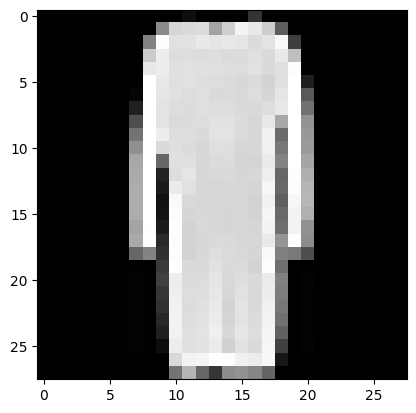

In [9]:
image, label = training_data[25]
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Now, here it comes the most important part: we have to fetch the GPU in order to use it instead of the CPU:

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We can now start to create our multilevel perceptron. It's important to define meticulously the two methods of the MLP class: the `init` method contains the basis for the MLP, while the `forward` method passes the data to the next layer.

The `nn.Sequential()` function is useful when creating the MLP because it allows to execute all the instructions inside such function sequentially. Within the `nn.Sequential()` function we have another function, `nn.Linear()`. Such function allows to define the input and output size in edges of our linear perceptron layer:

$$
\text{size}(a_{\text{in}}) \; \longrightarrow \; \text{size}(a_{\text{out}})
$$
$$
\mathbb{R}^i \; \longmapsto \; \mathbb{R}^j
$$

In [11]:
class OurMLP(nn.Module):
    def __init__(self, seq=True):
        if seq:
            super().__init__()
            self.mlp = nn.Sequential(
                # From this layer x we will export 50 edges to the next layer...
                nn.Linear(28 * 28, 50),
                nn.Sigmoid(),
                # ...then from 50 to 100...
                nn.Linear(50, 100),
                nn.Sigmoid(),
                # ...then from 100 to 50...
                nn.Linear(100, 50),
                nn.Sigmoid(),
                # ...then from 50 to 120, and so on and so forth...
                #nn.Linear(50, 120),
                #nn.Sigmoid(),
                #nn.Linear(120, 60),
                #nn.Sigmoid(),
                #nn.Linear(60, 50),
                #nn.Sigmoid(),

                # Output layer
                nn.Linear(50, 10)
            )
            self.flatten = nn.Flatten()
        else:
            super().__init__()
            self.input_layer = nn.Linear(28*28, 50)
            self.hidden1 = nn.Linear(50, 100)
            self.hidden2 = nn.Linear(100, 50)
            self.hidden3 = nn.Linear(50, 120)
            self.hidden4 = nn.Linear(120, 60)
            self.hidden5 = nn.Linear(60, 50)
            self.output_layer = nn.Linear(50, 10)
            self.activation = nn.Sigmoid()
            self.flatten = nn.Flatten()

    def forward(self, x, seq=True):
        if seq:
            x = self.flatten(x)
            logits = self.mlp(x)
            return logits
        else:
            x = self.input_layer(x)
            x = self.activation(x)
            x = self.flatten(x)
            logits = self.mlp(x)
            return logits

Now we must instantiate the model by defining the hyperparameters and the optimizer. The optimizer is the function in charge of tuning the parameters of the model, so it computes the necessary derivatives:

In [12]:
model = OurMLP().to(device)
model_no_seq = OurMLP(seq=False).to(device)

epochs = 5
batch_size = 16
learning_rate = 0.0001

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer. We can use either SGD or AdamW, but AdamW is more performant than SGD
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

We now need to create the data loader, which is in charge of taking the data from the disk and give it to the `pytorch` model:

In [13]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

We can also get some metrics from the model's performances, thanks to the `torchmetrics` package. We are using the `multiclass` parameter because our model will label each object with only one label, assigning such object to one class only; with the `multilabel` parameter our model would've assigned one object to multiple classes, thus assigning multiple labels to it:

In [14]:
metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

Now, finally, we define the training loop:

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch=None):
    """Trains an epoch of the model
    
    Parameters:
        - `dataloader`: the dataloader of the dataset
        - `model`: the model used
        - `loss_fn`: the loss function of the model
        - `optimizer`: the optimizer
        - `epoch`: the index of the epoch
    """
    size = len(dataloader)

    # Get the batch from the dataset
    for batch, (x, y) in enumerate(dataloader):
        # Move data to the device used
        x = x.to(device)
        y = y.to(device)

        # Compute the prediction and the loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Adjust the weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print some information
        if batch % 20 == 0:
            loss_value, current_batch = loss.item(), (batch + 1) * len(x)
            print(f"→ Loss: {loss_value} [Batch {current_batch}/{size}, Epoch {epoch}/{epochs}]")
            accuracy = metric(pred, y)
            print(f"Accuracy of batch {current_batch}/{size}: {accuracy}")
        
    accuracy = metric.compute()
    print(f"=== The epoch {epoch}/{epochs} has finished training ===")
    print(f"→ Final accuracy of the epoch: {accuracy}")
    metric.reset()

Now, this previous function is just the training loop for one epoch. We'll have to run it for all the epochs that we want to have. We now just need to define the test loop and we are ready to run the model:

In [16]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)

    # Disable the updating of the weights
    with torch.no_grad():
        for index, (x, y) in enumerate(dataloader):
            # Move the data to the device used for testing
            x = x.to(device)
            y = y.to(device)

            # Get the model prediction
            pred = model(x)

            # Get the accuracy score
            acc = metric(pred, y)
            print(f"→ Accuracy for image {index}: {acc}")
    acc = metric.compute()
    print(f"=== The testing loop has finished ===")
    print(f"→ Final testing accuracy of the model: {accuracy}")
    metric.reset()

Finally, we can train the model:

In [17]:
for epoch_ind in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_ind)
    test_loop(test_dataloader, model, loss_fn)

print("=== The training has finished ===")

→ Loss: 2.3128719329833984 [Batch 16/3750, Epoch 0/5]
Accuracy of batch 16/3750: 0.125
→ Loss: 2.2943038940429688 [Batch 336/3750, Epoch 0/5]
Accuracy of batch 336/3750: 0.0
→ Loss: 2.3291964530944824 [Batch 656/3750, Epoch 0/5]
Accuracy of batch 656/3750: 0.0
→ Loss: 2.2258284091949463 [Batch 976/3750, Epoch 0/5]
Accuracy of batch 976/3750: 0.25
→ Loss: 2.3320088386535645 [Batch 1296/3750, Epoch 0/5]
Accuracy of batch 1296/3750: 0.0625
→ Loss: 2.283327341079712 [Batch 1616/3750, Epoch 0/5]
Accuracy of batch 1616/3750: 0.0625
→ Loss: 2.2853291034698486 [Batch 1936/3750, Epoch 0/5]
Accuracy of batch 1936/3750: 0.125
→ Loss: 2.3331735134124756 [Batch 2256/3750, Epoch 0/5]
Accuracy of batch 2256/3750: 0.0
→ Loss: 2.264916181564331 [Batch 2576/3750, Epoch 0/5]
Accuracy of batch 2576/3750: 0.25
→ Loss: 2.3006837368011475 [Batch 2896/3750, Epoch 0/5]
Accuracy of batch 2896/3750: 0.125
→ Loss: 2.2652618885040283 [Batch 3216/3750, Epoch 0/5]
Accuracy of batch 3216/3750: 0.25
→ Loss: 2.30562734

We can also train a non sequential model. We just repeat the two previous steps with the non sequential model:

In [ ]:
for epoch_ind in range(epochs):
    train_loop(train_dataloader, model_no_seq, loss_fn, optimizer, epoch_ind)

test_loop(test_dataloader, model_no_seq, loss_fn)

print("=== The training has finished ===")